# Extraction of Numbeo Data

In [ ]:
import csv,fnmatch,os,re,pickle
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
from sklearn.cross_validation import StratifiedKFold,cross_val_score
from sklearn.linear_model import SGDClassifier
from scipy import interp
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from time import time
from numbeo_data_acquisition import *
from feature_engineering import *

### Get Numbeo : loading serialized files or downloading data according to the location or the region / country from numbeo API

In [ ]:
data_folder = '/home/thebatou/Documents/Uni_Potsdam/data_analysis_bitbond/data/'
file_name = 'project_data_train_v2.csv'
file_location = os.path.join(data_folder, file_name)

print 'Trying to load bitbond data ...'
bitbond_data = pd.read_csv(file_location, index_col=0)
bitbond_data.set_value([835, 1232, 1839, 1993], 'region', 'NA')
bitbond_data.set_value([1364, 1366, 1374, 1425, 1459, 1580, 1753], 'currency', 'USD')
bitbond_data.set_value([1362, 1368], 'currency', 'HUF')
bitbond_data.set_value([1360, 1416, 1525, 1921], 'currency', 'IDR')
bitbond_data.set_value([1384, 1428, 1463, 1553, 1574, 1628, 1808], 'currency', 'INR')
bitbond_data.set_value([1369, 1435, 1693], 'currency', 'KES')
print 'Done loading bitbond data! {} data were loaded.'.format(bitbond_data.shape[0])

try:
    print ("Trying to load numbeo data about region ...")
    file_location1 = os.path.join(data_folder, 'numbeo_region_prices.csv')
    region_prices_numbeo = pd.read_csv(file_location1, index_col=0)
    print "Done loading region numbeo data! {} data were loaded.".format(region_prices_numbeo.shape[0])    

    print ("Trying to load numbeo data about country ...")
    file_location2 = os.path.join(data_folder, 'numbeo_country_prices.csv')
    country_prices_numbeo = pd.read_csv(file_location2, index_col=0)
    print "Done loading country numbeo data! {} data were loaded.".format(country_prices_numbeo.shape[0])
    
    print ("Trying to load numbeo data about city ...")
    file_location3 = os.path.join(data_folder, 'numbeo_city_prices.csv')
    city_prices_numbeo = pd.read_csv(file_location3, index_col=0)
    print "Done loading city numbeo data! {} data were loaded.".format(city_prices_numbeo.shape[0])
    
    
except IOError as e:
    print "I/O error: {0}".format(e)
    print "Downloading data from numbeo website ..."
    quadruple_id_lat_long_region = bitbond_data.groupby(by=('loan_identifier','address_lat','address_lng','region')).indices.keys()
    (all_city_prices_requests, all_country_prices_requests, missing_prices_location) =  get_numbeo_data_according_to_location(quadruple_id_lat_long_region)
    print 'Missing value : {}'.format(len(missing_prices_location) != 0)
    
    city_prices_numbeo = pd.DataFrame(all_city_prices_requests)
    city_prices_numbeo['prices'] = average_salary_extraction(city_prices_numbeo['prices'])
    city_prices_numbeo.to_csv(path_or_buf=file_location3, encoding='utf-8')
    
    country_prices_numbeo = pd.DataFrame(all_country_prices_requests)
    country_prices_numbeo['prices'] = average_salary_extraction(country_prices_numbeo['prices'])
    country_prices_numbeo.to_csv(path_or_buf=file_location2, encoding='utf-8')
    
    regions = np.unique(bitbond_data.region)
    (all_region_prices_requests, missing_prices_regions) = get_numbeo_data_according_to_region(regions)
    print 'Missing value : {}'.format(len(missing_prices_regions) != 0)

    region_prices_numbeo = pd.DataFrame(all_region_prices_requests)
    region_prices_numbeo['prices'] = average_salary_extraction(region_prices_numbeo['prices'])
    region_prices_numbeo.to_csv(path_or_buf=file_location1, encoding='utf-8')

In [ ]:
print 'Bitbond data shape : {}'.format(bitbond_data.shape)
print 'City numbeo data has shape : {}'.format(city_prices_numbeo.shape)
print 'Country numbeo data has shape : {}'.format(country_prices_numbeo.shape)
print '\nFirst element of city numbeo data :'
print city_prices_numbeo.ix[0]
print '\nFirst element of country numbeo data :'
print country_prices_numbeo.ix[2]

### Cleaning bitbond data + Droping some useless data collected from Numbeo

In [ ]:
bitbond_data = bitbond_data.replace(to_replace=np.nan, value=-1)

def drop_useless_column(dataframe):
    dataframe.drop('currency',axis=1,inplace=True)
    dataframe.drop('contributors',axis=1,inplace=True)
    dataframe.drop('monthLastUpdate',axis=1,inplace=True)
    dataframe.drop('yearLastUpdate',axis=1,inplace=True)
    dataframe = dataframe.rename(columns={'name':'location'})
    return dataframe

city_prices_numbeo = drop_useless_column(city_prices_numbeo)
country_prices_numbeo = drop_useless_column(country_prices_numbeo)
region_prices_numbeo = drop_useless_column(region_prices_numbeo)

In [ ]:
print "Nombre de pair (lat, lon) unique : {}".format(len(bitbond_data.groupby(by=('address_lat','address_lng')).indices.keys()))
print "Nombre d'emprunteur : {}".format(len(np.unique(bitbond_data['borrower_identifier'])))

l1 = bitbond_data.groupby(by=('address_lat','address_lng','borrower_identifier')).indices.keys()
l2 = [(e[0],e[1]) for e in l1]
borrowers_without_address = [e[2] for e in l1 if l2.count((e[0],e[1])) > 1]
# We substract 1 because of the pair (-1,-1) in the unique addresses (pair)
print "Nombre d'emprunteur sans adresses : {}".format(len(borrowers_without_address))

#bitbond_data.loc[bitbond_data['borrower_identifier'].isin(borrowers_without_address)]

### Merging the bitbond data with the numbeo data to make one unique dataset

In [ ]:
bitbond_numbeo_data = pd.merge(bitbond_data, region_prices_numbeo, on=['region'], how='left')
bitbond_numbeo_data_2 = pd.merge(bitbond_numbeo_data, country_prices_numbeo, on=['loan_identifier','region','prices', 'location'], how='left')
data = pd.merge(bitbond_numbeo_data_2, city_prices_numbeo, on=['loan_identifier','address_lat', 'address_lng', 'prices', 'location'], how='left')
data.to_csv(path_or_buf=os.path.join(data_folder,'data_num_bit.csv'), encoding='utf-8')

# Classification task

In [1]:
import csv,fnmatch,os,re,pickle
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
from sklearn.cross_validation import StratifiedKFold,cross_val_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from scipy import interp
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from time import time
from numbeo_data_acquisition import *
from feature_engineering import *
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

In [2]:
file_loc = '/home/thebatou/Documents/Uni_Potsdam/data_analysis_bitbond/data/data_num_bit.csv'
print ("Trying to load the data ...")
data = pd.read_csv(file_loc, index_col=0)
print "Done loading the data! {} data were loaded.".format(data.shape)    
data = data.set_value([835, 1232, 1839, 1993], 'region', 'NA')

Trying to load the data ...
Done loading the data! (2177, 30) data were loaded.


In [ ]:
#data[~data['location'].isin(np.unique(data['location'])[1:])]

In [ ]:
print 'Nominal interest rate : {}'.format(np.unique(data.nominal_interest_rate))
print 'Term : {}'.format(np.unique(data.term))
print 'Purpose : {}'.format(np.unique(data.purpose))
print 'Borrower rating : {}'.format(np.unique(data.borrower_rating))
print 'Employment : {}'.format(np.unique(data.employment))
print 'Region : {}'.format(np.unique(data.region))
print 'Prices : {}'.format(np.unique(data.prices))
print 'Facebook : {}'.format(np.unique(data.facebook))
print 'Ebay : {}'.format(np.unique(data.ebay))
print 'Status : {}'.format(np.unique(data.status))
print 'Fraudulent : {}'.format(np.unique(data.fraudulent))
print 'Currency : {}'.format(np.unique(data.currency))
print 'Rates count : {}'.format(np.unique(data.rates_count))
print 'Rates paid : {}'.format(np.unique(data.rates_paid))
print 'Base currency : {}'.format(np.unique(data.base_currency))
print 'Location : {}'.format(np.unique(data.location))

### Transformation of the data : building the features

In [3]:
data['average_salary'] = data['net_income_cents'] / data['prices']
data['average_salary'] = pd.DataFrame(preprocessing.scale(data['average_salary']))
classif_data = data.loc[data['status'].isin(['defaulted', 'fully_paid', 'late_90', 'charged_off'])]
classif_data = classif_data.copy().reset_index()

In [4]:
print 'Shape of the data : {}'.format(classif_data.shape)

Shape of the data : (608, 32)


In [5]:
y = classif_data['status'] == 'fully_paid'
y = y.as_matrix()
classif_data.drop('status',axis=1,inplace=True)

In [6]:
classif_data.drop('loan_identifier',axis=1,inplace=True)
classif_data.drop('nominal_interest_rate',axis=1,inplace=True)
classif_data.drop('borrower_identifier',axis=1,inplace=True)
classif_data.drop('borrower_rating',axis=1,inplace=True)
classif_data.drop('region',axis=1,inplace=True)
classif_data.drop('facebook',axis=1,inplace=True)
classif_data.drop('twitter',axis=1,inplace=True)
classif_data.drop('paypal',axis=1,inplace=True)
classif_data.drop('ebay',axis=1,inplace=True)
classif_data.drop('linkedin',axis=1,inplace=True)
classif_data.drop('published_at',axis=1,inplace=True)
classif_data.drop('funded_at',axis=1,inplace=True)
classif_data.drop('amount_requested',axis=1,inplace=True)
classif_data.drop('amount_funded',axis=1,inplace=True)
classif_data.drop('issuer_id',axis=1,inplace=True)
classif_data.drop('fraudulent',axis=1,inplace=True)
classif_data.drop('address_lat',axis=1,inplace=True)
classif_data.drop('address_lng',axis=1,inplace=True)
classif_data.drop('net_income_cents',axis=1,inplace=True)
classif_data.drop('currency',axis=1,inplace=True)
classif_data.drop('base_currency',axis=1,inplace=True)
classif_data.drop('rates_count',axis=1,inplace=True)
classif_data.drop('rates_paid',axis=1,inplace=True)
classif_data.drop('location',axis=1,inplace=True)
classif_data.drop('prices',axis=1,inplace=True)
#classif_data.drop('project_description',axis=1,inplace=True)

In [11]:
categorical_feature = ['term', 'purpose', 'employment']
other_feature = [column for column in classif_data.columns.tolist() if column not in categorical_feature]

_, binarized_feat = build_categorical_feature(classif_data,categorical_feature,binary_encoding=True)
_, unbinarized_feat = build_categorical_feature(classif_data,categorical_feature)
previous_index = binarized_feat['index']
binarized_feat.drop('index', inplace=True, axis=1)
unbinarized_feat.drop('index', inplace=True, axis=1)
final_bin_data = text_transformation(binarized_feat)
final_unbin_data = text_transformation(unbinarized_feat)

done in 2.422s.
done in 2.426s.


In [ ]:
def get_similar(doc_id, doc_topic_distribution):
    doc_rep = np.array([doc_topic_distribution[doc_id]]*len(doc_topic_distribution))
    sim = np.dot(((np.log(doc_rep)-np.log(doc_topic_distribution))),doc_topic_distribution[doc_id])
    return sim.argsort()

In [ ]:
docs_topics_norm = articles_topics/articles_topics.sum(axis=1)[:,None]
similar_docs = get_similar(1,docs_topics_norm)
similar_docs[1:11]

In [ ]:
print cl_data.project_description.ix[1]
print cl_data.project_description.ix[16]

In [12]:
X_bin = final_bin_data.as_matrix()
X_unb = final_unbin_data.as_matrix()
print 'Shape of X_bin : {}'.format(X_bin.shape)
print 'Shape of X_unb : {}'.format(X_unb.shape)
print 'Shape of y : {}'.format(y.shape)

Shape of X_bin : (608, 37)
Shape of X_unb : (608, 24)
Shape of y : (608,)


In [ ]:
from scipy.stats import pearsonr

print pearsonr(feat.term,feat.purpose)
print pearsonr(feat.term,feat.employment)
print pearsonr(feat.employment,feat.purpose)
print pearsonr(feat.term,feat.average_salary)
print pearsonr(feat.purpose,feat.average_salary)
print pearsonr(feat.employment,feat.average_salary)

explained variance ratio (first two components): [ 38.4  15.3  14.1  11.4   5.2   3.7   3.4   2.7   2.1   1.4] 97.7


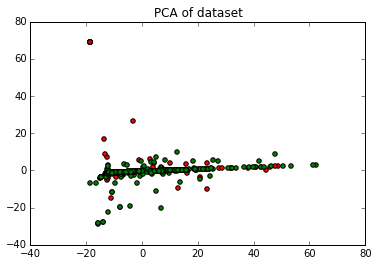

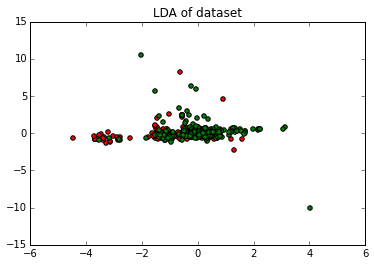

In [14]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pca = PCA(n_components=10)
X_r = pca.fit(X_unb).transform(X_unb)

lda = LinearDiscriminantAnalysis(n_components=10)
X_r2 = lda.fit(X_unb, y).transform(X_unb)

# Percentage of variance explained for each components
print 'explained variance ratio (first two components): {} {}'.format(np.around(pca.explained_variance_ratio_*100, decimals=1),
                                                                      np.sum(np.around(pca.explained_variance_ratio_*100, decimals=1)))

plt.figure()
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], c=c)
plt.legend()
plt.title('PCA of dataset')

plt.figure()
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], c=c)
plt.legend()
plt.title('LDA of dataset')

plt.show()

Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False):
             precision    recall  f1-score   support

      False       0.67      0.32      0.44        37
       True       0.71      0.91      0.79        66

avg / total       0.69      0.70      0.67       103


Confusion matrix:
[[12 25]
 [ 6 60]]
Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False):
             precision    recall  f1-score   support

      False       0.59      0.36      0.45        36
       True       0.71      0.86  

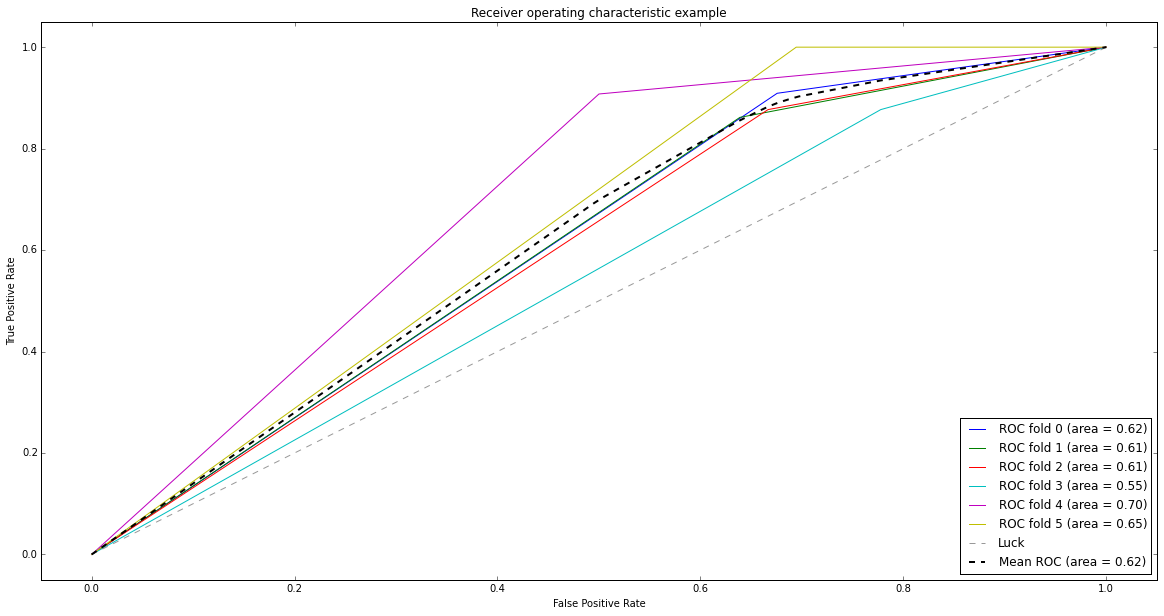

In [20]:
#y = data['status'] != 'fully_paid'

#v = DictVectorizer()
#D = data.loc[:,['amount_funded','amount_requested']].T.to_dict().values()
#.to_dict()#,'address_lat','address_lng' , 'net_income_cents'
                #'nominal_interest_rate', 'prices', 'rates_count', 'rates_paid']]
#X = v.fit_transform(D)

X = X_r2

random_state = np.random.RandomState(0)

cv = StratifiedKFold(y, n_folds=6)
#clf = svm.SVC(kernel='linear', probability=True, random_state=random_state)
clf = LogisticRegression()

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
scores = []

plt.figure(figsize=(20,10))

for i, (train, test) in enumerate(cv):
    clf.fit(X[train], y[train])
    scores.append(clf.score(X[test], y[test]))
    y_scores = clf.predict(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], y_scores)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    # Now predict the value of the digit on the second half:
    expected = y[test]
    predicted = clf.predict(X[test])

    print("Classification report for classifier %s:\n%s\n"
          % (clf, metrics.classification_report(expected, predicted)))
    print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.cross_validation import ShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.utils import check_random_state
from sklearn import datasets


rnd = check_random_state(1)

n_samples = X.shape[0]

# l1 data (only 5 informative features)
X_1, y_1 = X, y

# l2 data
X_2, y_2 = X, y

clf_sets = [(LinearSVC(penalty='l1', loss='squared_hinge', dual=False, tol=1e-3),
             np.logspace(-2.3, 1.3, 10), X_1, y_1),
            (LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=1e-4),
             np.logspace(-4.5, 2, 10), X_2, y_2)]

colors = ['b', 'g', 'r', 'c']

for fignum, (clf, cs, X, y) in enumerate(clf_sets):
    # set up the plot for each regressor
    plt.figure(fignum, figsize=(9, 10))

    for k, train_size in enumerate(np.linspace(0.3, 0.7, 3)[::-1]):
        param_grid = dict(C=cs)
        # To get nice curve, we need a large number of iterations to
        # reduce the variance
        grid = GridSearchCV(clf, refit=False, param_grid=param_grid,
                            cv=ShuffleSplit(n=n_samples, train_size=train_size,
                                            n_iter=250, random_state=1))
        grid.fit(X, y)
        scores = [x[1] for x in grid.grid_scores_]

        scales = [(1, 'No scaling'),
                  ((n_samples * train_size), '1/n_samples'),
                  ]

        for subplotnum, (scaler, name) in enumerate(scales):
            plt.subplot(2, 1, subplotnum + 1)
            plt.xlabel('C')
            plt.ylabel('CV Score')
            grid_cs = cs * float(scaler)  # scale the C's
            plt.semilogx(grid_cs, scores, label="fraction %.2f" %
                         train_size)
            plt.title('scaling=%s, penalty=%s, loss=%s' %
                      (name, clf.penalty, clf.loss))

    plt.legend(loc="best")
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score

#random_state = np.random.RandomState(0)

cv = StratifiedKFold(y, n_folds=6)
clf = DecisionTreeClassifier(random_state=0)
#clf = svm.SVC(probability=True)

cross_val_score(clf, X, y, cv=10)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
scores = []

plt.figure(figsize=(20,10))

for i, (train, test) in enumerate(cv):
    clf.fit(X[train], y[train])
    scores.append(clf.score(X[test], y[test]))
    y_scores = clf.predict(X[test]) #decision_function(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], y_scores)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    expected = y[test]
    predicted = clf.predict(X[test])

    print("Classification report for classifier %s:\n%s\n"
          % (clf, metrics.classification_report(expected, predicted)))
    print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()